# 프로젝트: SentencePiece 사용하기

## 회고
* Sentencepiece, Konlpy에서 제공하는 tokenizer 등 간의 성능을 비교할 수 있었다. 
* test accuracy가 생각보다 안 올랐다. 

### 활용 데이터 
* 파일명: korean-english-park.train.ko
* 데이터 설명: 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터
* 출처: https://github.com/jungyeul/korean-parallel-corpora

In [2]:
!pip install sentencepiece

In [3]:
# library import
from konlpy.tag import *

import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore') 

%matplotlib inline

import sentencepiece as spm

## 데이터 분석

### Distribution 확인

In [4]:
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("** Data Size:", len(raw),'**')

print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

** Data Size: 94123 **
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


=> 코드 실행 결과
* 데이터가 총 94123개의 문장으로 이뤄져있다. 

In [5]:
# 문장 길이 확인 - 방법1
length_lst = []

for sentence in raw:
    length_lst.append(len(sentence))

raw_size = len(length_lst)
max_len = max(length_lst)
min_len = min(length_lst)

print(f'corpus 크기: {raw_size}')
print(f'문장 최소 길이: {min_len}')
print(f'문장 최장 길이: {max_len}')
print(f'문장 평균 길이: {sum(length_lst)/raw_size}')

corpus 크기: 94123
문장 최소 길이: 1
문장 최장 길이: 377
문장 평균 길이: 60.78048935966767


In [6]:
# 문장 길이 확인 - 방법2

min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


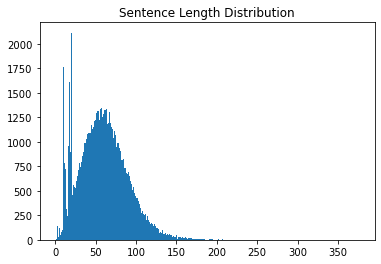

In [7]:
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [8]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


=> 문장 길이가 1인 경우에 '과 같은 유의미하지 않은 문장부호가 들어가 있는 경우를 확인했다. 

In [9]:
for idx, _sum in enumerate(sentence_length):
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


=> 같은 문장 길이를 1500개 이상 가지고 있는 경우의 인덱스는 11, 19, 21임을 확인합니다.

### Noise 확인 및 정제
- Duplicated sentence
- Null data
- Delete Too short/long sentence length

In [10]:
# Delete duplicated sentence 
print("중복 데이터 제거 전 :", len(raw))

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.

print("중복 데이터 제거 후 :", len(cleaned_corpus))

중복 데이터 제거 전 : 94123
중복 데이터 제거 후 : 77591


=> 약 2만개 정도의 중복 데이터 문장들이 있었음을 알 수 있다. 

In [11]:
# Delete Null data 
print(f'Null값 제거 전: {len(cleaned_corpus)}')

for idx in range(len(cleaned_corpus)):
    # # 문장 길이 0이면 삭제 
    if len(cleaned_corpus[idx]) == 0:
        #print("Null Index:", idx+1)
        cleaned_corpus.pop(idx)
        
print(f'Null값 제거 후: {len(cleaned_corpus)}')

Null값 제거 전: 77591
Null값 제거 후: 77591


=> null값은 없다.

In [12]:
# 길이 5 이하인 문장 확인하기
check_sentence_with_length(cleaned_corpus, 1)

’


In [13]:
# 길이 5 이하인 문장 확인하기
check_sentence_with_length(cleaned_corpus, 2)

6.
4.
과일
면접
양파
2.
햇빛
3.
음식
Q:
1.
..


In [14]:
# 길이 5 이하인 문장 확인하기
check_sentence_with_length(cleaned_corpus, 3)

통계청
철도청
이벤트
단어장
ST.
감사원
교훈:
▲쇼핑
프린트
MMR
첫째날
둘째날
코브:
버뮤다


In [15]:
# 길이 5 이하인 문장 확인하기
check_sentence_with_length(cleaned_corpus, 4)

외딴 곳
용어사전
자유!”
통합사전
요한슨:
보조식품
*유방암
어휘 :
한자사전
국어사전
원문기사
5.버섯
일어사전
(원제:
* 장소
첫인상:
-가족-
첫번째:
번역 :
기사공유
영어사전
2.계란
사와야:
한나라당
신생아:
3.커피
그렇죠?


In [16]:
# 길이 5 이하인 문장 확인하기
check_sentence_with_length(cleaned_corpus, 5)

산업자원부
“나중에”
문화·연예
면접 이후
▲레스토랑
해외 송금
-남자들-
▲버스투어
분열 조장
햇볕 쬐기
7. 지압
*심장질환
*산부인과
인권 침해
배신자!”
세부사항:
나를 봐"
11.지각


=> 특수문장을 제외하고 의미있는 단어를 내포하고 있는지 살펴보면 길이가 2만 되어도 괜찮다는 것을 알 수 있다. 해당 모델은 tokenizer를 만들기 위함이기 때문에 짧은 문장의 데이터를 사용해도 괜찮을 것으로 생각된다. 이를 실험적으로 이후 단계에서 확인해볼 예정이다.

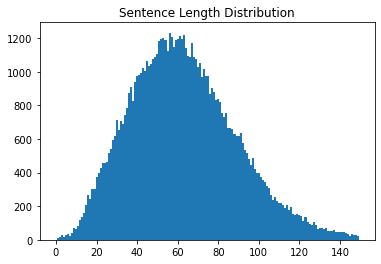

In [17]:
# 문장 길이를 기준으로 필터링
max_len = 150
min_len = 2

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) <= max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1 # length 같으면 같은 인덱스의 값을 +1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [18]:
# cleaned_corpus 데이터형 확인 
type(cleaned_corpus)

list

In [19]:
# Noise 처리 후 문장 길이 확인 & distribution 

# 문장 길이 확인
length_lst = []

for sentence in filtered_corpus:
    length_lst.append(len(sentence))

filtered_corpus_size = len(length_lst)
max_len = max(length_lst)
min_len = min(length_lst)

print(f'corpus 크기: {filtered_corpus_size}')
print(f'문장 최소 길이: {min_len}')
print(f'문장 최장 길이: {max_len}')
print(f'문장 평균 길이: {sum(length_lst)/raw_size}')

corpus 크기: 77127
문장 최소 길이: 2
문장 최장 길이: 150
문장 평균 길이: 52.3682734294487


<AxesSubplot:ylabel='count'>

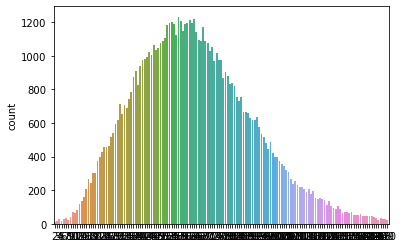

In [20]:
# Seaborn을 활용한 분포 확인
import seaborn as sns

sns.countplot(length_lst)

## Tokenization

### Sentencepiece 학습 및 테스트
* 기본적으로 <unk>, <s>, </s> 는 0, 1, 2 순으로 정의됩니다. 
    
#### 변경 가능한 파라미터 
* vocab_size: 단어사전의 크기 
* model_type: unigram과 bpe

In [21]:
len(filtered_corpus)

77127

#### vocab size=8000, model type=unigram

In [69]:
# 모델 학습
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_uni_8000 --vocab_size={} --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 '.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [70]:
!ls -l korean_spm_uni_*

-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 376873  4월 20 11:03 korean_spm_uni_8000.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 146298  4월 20 11:03 korean_spm_uni_8000.vocab


In [71]:
# 모델 불러오기
s = spm.SentencePieceProcessor()
s.Load('korean_spm_uni_8000.model')

True

In [72]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1248, 12, 306, 8, 3607, 12, 285, 39, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


#### vocab size=8000, model type=bpe

In [73]:
# 모델 학습
spm.SentencePieceTrainer.Train(
    f'--input={temp_file} --model_prefix=korean_spm_bpe_8000 --vocab_size={vocab_size} --model_type=bpe --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3'    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [74]:
!ls -l korean_spm_bpe*

-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 598475  4월 20 11:00 korean_spm_bpe_20000.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 329655  4월 20 11:00 korean_spm_bpe_20000.vocab
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 371925  4월 20 11:03 korean_spm_bpe_8000.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 117116  4월 20 11:03 korean_spm_bpe_8000.vocab
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 604878  4월 19 18:55 korean_spm_bpe.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 336088  4월 19 18:55 korean_spm_bpe.vocab


In [75]:
# 모델 불러오기
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe_8000.model')

True

In [76]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1522, 1155, 6619, 6709, 2646, 6781, 6684, 6686]
['▁아버', '지가', '방에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


#### vocab size=20000, model type=bpe

In [77]:
# 모델 학습
vocab_size = 20000

spm.SentencePieceTrainer.Train(
    f'--input={temp_file} --model_prefix=korean_spm_bpe_20000 --vocab_size={vocab_size} --model_type=bpe --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3'    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [78]:
!ls -l korean_spm_bpe*

-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 604885  4월 20 11:04 korean_spm_bpe_20000.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 336070  4월 20 11:04 korean_spm_bpe_20000.vocab
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 371925  4월 20 11:03 korean_spm_bpe_8000.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 117116  4월 20 11:03 korean_spm_bpe_8000.vocab
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 604878  4월 19 18:55 korean_spm_bpe.model
-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 336088  4월 19 18:55 korean_spm_bpe.vocab


In [79]:
# 모델 불러오기
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe_20000.model')

True

In [80]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[7661, 6619, 18709, 2646, 18781, 18684, 18686]
['▁아버지가', '방에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


## Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

### 여러 옵션으로 학습한 Tokenizer
* korean_spm_uni_8000
* korean_spm_bpe_8000
* korean_spm_bpe_20000

In [45]:
def sp_tokenize(s, corpus, max_len_):

    tensor = []
    
    s.SetEncodeExtraOptions('bos:eos')
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./" + s_option + ".vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen = max_len_, padding='post')

    return tensor, word_index, index_word

In [34]:
# 학습한 토크나이저 선택 
s_option = 'korean_spm_uni_8000'

s = spm.SentencePieceProcessor()
s.Load(s_option+'.model')

True

In [82]:
print(s.get_piece_size()) # vocab size

20000


In [84]:
print(s.id_to_piece(0))
print(s.id_to_piece(1))
print(s.id_to_piece(2))
print(s.id_to_piece(3))
print(s.piece_to_id('.'))

<pad>
<s>
</s>
<unk>
18686


In [88]:
for id in range(4):
    print(s.id_to_piece(id), s.is_control(id))

<pad> True
<s> True
</s> True
<unk> False


In [46]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 20)
print(tensor)

[[   1 1954 5660    5    4 7975 1984    3    2    0    0    0    0    0
     0    0    0    0    0    0]
 [   1  107 1637  101    4    0  420   11    4   14    0 1971    3    3
     3    2    0    0    0    0]]


In [47]:
print(s.SampleEncodeAsPieces(my_corpus[0], 1, 0.0))

['<s>', '▁나는', '▁밥', '을', '▁', '먹', '었습니다', '.', '</s>']


In [48]:
print(s.SampleEncodeAsPieces(my_corpus[1], 1, 0.0))

['<s>', '▁그러나', '▁여전', '히', '▁', 'ᅲᅲ', '▁배', '가', '▁', '고', '픕', '니다', '.', '.', '.', '</s>']


In [49]:
# 문장 양 끝에 <s>, </s>를 추가 
s.SetEncodeExtraOptions('bos:eos')
print(s.SampleEncodeAsPieces(my_corpus[1], 1, 0.0))

['<s>', '▁그러나', '▁여전', '히', '▁', 'ᅲᅲ', '▁배', '가', '▁', '고', '픕', '니다', '.', '.', '.', '</s>']


In [40]:
tensor.shape

(2, 20)

## 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

### 데이터 셋팅
* 데이터불러오기
* 데이터셋 개수 확인 
* 라벨 분포 확인 

In [50]:
# 데이터 불러오기
train_data = pd.read_table('~/aiffel/sp_tokenizer/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/data/ratings_test.txt')

In [51]:
# 데이터 개수 확인 
print("train set: {}개".format(len(train_data)))
print("test set: {}개".format(len(test_data)))

train set: 150000개
test set: 50000개


In [52]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [53]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


<AxesSubplot:>

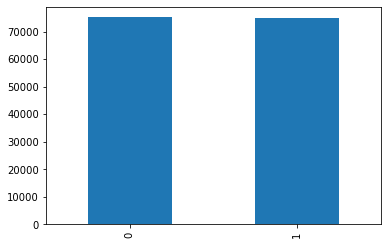

In [54]:
# label의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [55]:
train_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

### 데이터 전처리  
* 문장 분포 확인
* 중복 제거 
* Null값 제거 

In [95]:
len(train_data['document'][1])

33

---

In [68]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [89]:
# 정제된 데이터를 공백 기반으로 토큰화하여 저장하는 코드를 직접 작성해 보세요.
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [90]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237532


In [91]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


* mecab: https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html

In [98]:
mecab = Mecab()

def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [99]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52287


In [100]:
# Case 1
texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

호리 군 소방서 의 게리 알더 만 서장 은 연기 가 소방대원 들 의 발목 을 잡 고 있 다고 전했 습니다 .


In [101]:
# Case 2
sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

호리 군 소방서 의 게리 알더 만 서장 은 연기 가 소방대원 들 의 발목 을 잡 고 있 다고 전했 습니다 . 
